## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



**Extrait de "ai4i2020.csv"**

UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF

1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0

2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0

## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [2]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter

**QUESTION:** Load dataset and display some lines of the csv file.

In [24]:
df = pd.read_csv("ai4i2020.csv")
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

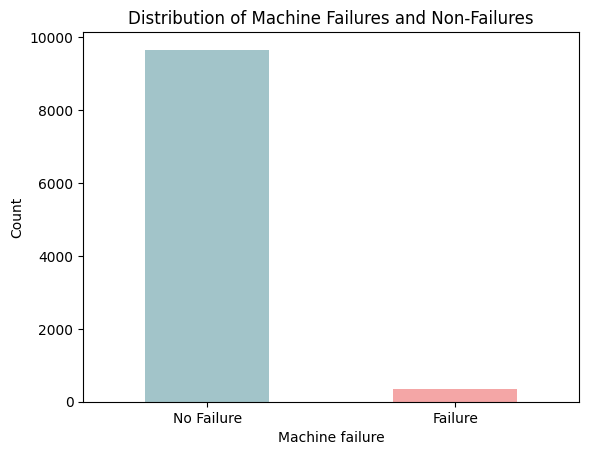

In [25]:
failure_counts = df['Machine failure'].value_counts()
failure_counts.plot(kind='bar', color=['#A2C4C9', '#F4A6A6'])
plt.xticks(ticks=[0, 1], labels=['No Failure', 'Failure'], rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

En observant la distribution des pannes et des non-pannes, on remarque que la majorité des machines ne subissent pas de panne. Cela indique un déséquilibre de classe dans le dataset, où les instances de "No Failure" sont beaucoup plus nombreuses que celles de "Failure".

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Ce déséquilibre peut entraîner un biais dans le modèle, qui pourrait prédire majoritairement "No Failure" sans apprendre à identifier correctement les cas de panne. Cela réduirait la capacité du modèle à détecter les pannes, ce qui est pourtant l'objectif principal de la maintenance prédictive.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

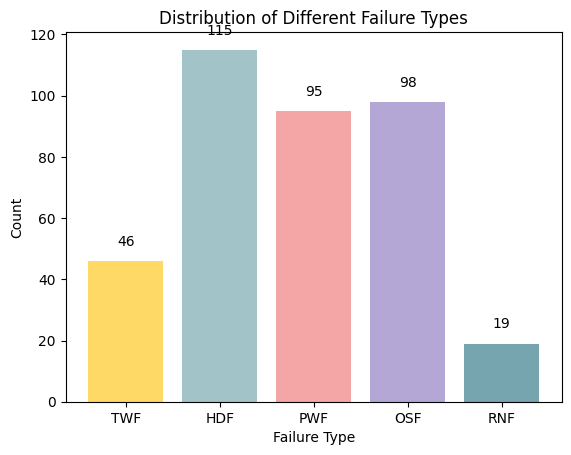

In [26]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6', '#76A5AF']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
for i, v in enumerate(failure_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.show()

**ANALYSIS QUESTION:** What do you observe?

 La distribution des différents types de pannes montre que certaines pannes, comme HDF, OSF et PWF, sont plus fréquentes que d'autres, comme RNF. Cela suggère que certaines pannes sont plus courantes dans les données disponibles.

 De plus, on constate que 5% des pannes sont aléatoires. Hors, elle ne peuvent pas être prévisibles par un modèle.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

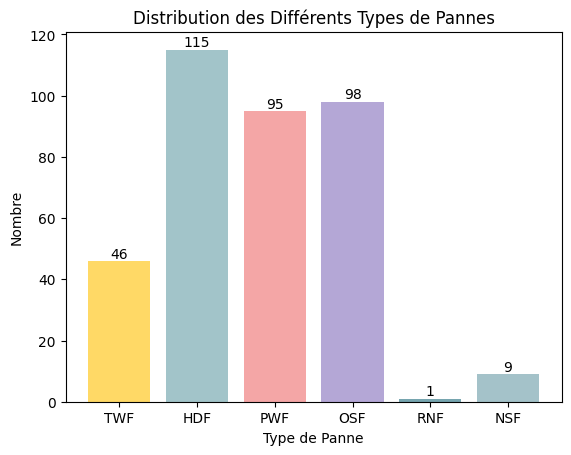

In [27]:
failed_machines = df[df['Machine failure'] == 1]

failure_counts = failed_machines[failure_types].sum()

failure_counts['NSF'] = (failed_machines[failure_types].sum(axis=1) == 0).sum()


colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6', '#76A5AF', '#A4C2C9']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Type de Panne')
plt.ylabel('Nombre')
plt.title('Distribution des Différents Types de Pannes')

for i, count in enumerate(failure_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

On remarque que par rapport a la question précédente ou le label RNF s'active 19 fois, ici lorsqu'on regarde uniquement les fois où la machine tombe vraiment en panne, le label RNF ne s'active 1 seule fois ce qui signifie que 18 des 19 fois ou le label RNF valait 1 la machine n'est pas tombé en panne. 

De plus, on remarque que 9 fois il y a eu une panne sans qu'aucun label la prédise.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

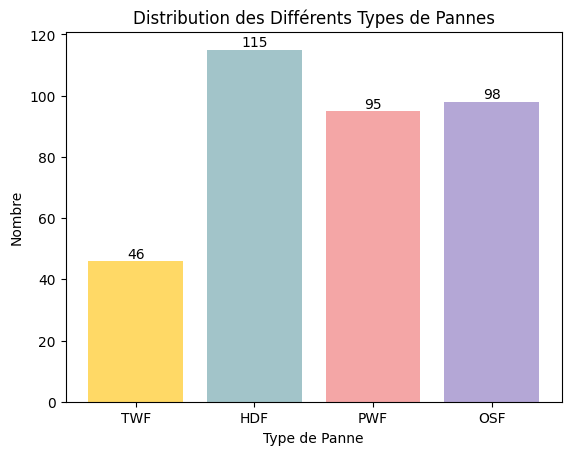

In [28]:
#on enlève RNF car apparait qu'une seule fois, car Random donc difficile à prédire et 18 fois où RNF vaut 1 et Machine failure = 0 donc problème 
#on enlève aussi les NSF: car on peut pas les prédire

failure_types_ok = ['TWF', 'HDF', 'PWF', 'OSF']
failed_machines = df[df['Machine failure'] == 1]

failure_counts = failed_machines[failure_types_ok].sum()


colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Type de Panne')
plt.ylabel('Nombre')
plt.title('Distribution des Différents Types de Pannes')

for i, count in enumerate(failure_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

 Les entrées seront les caractéristiques des machines telles que la température de l'air, la température du processus, la vitesse de rotation, le couple et l'usure de l'outil. 
 
 Les sorties seront les labels indiquant si une panne n'a PAS eu lieu (NF) et les 4 types de pannes (TWF, HDF, PWF, OSF). 
 
 Cela est justifié par l'objectif de prédire les pannes et leurs types en fonction des conditions opérationnelles des machines. Ce qui n'aurait pas été possible en gardant le label Failure.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [29]:
# Remove cases where RNF == 1 pour machine failure =0 ou =1
df = df[df['RNF'] == 0]

# Remove cases where Machine failure == 1 but no specific failure type is recorded
failure_types_ok = ['TWF', 'HDF', 'PWF', 'OSF']
df = df[~((df['Machine failure'] == 1) & (df[failure_types_ok].sum(axis=1) == 0))]

# Drop RNF column
df = df.drop(columns=['RNF'])
#add NF column = l'inverse de machine failure
df['NF'] = (df['Machine failure'] == 0).astype(int)
# Drop RNF column
df = df.drop(columns=['Machine failure'])

# Display first lines of the dataset
print(df.head())
print(len(df))  # Nombre total de lignes

#df = df[df[failure_types_ok].sum(axis=1) < 2]
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y = df[['TWF', 'HDF', 'PWF', 'OSF', 'NF']]  #les labels sont encodés en one-hot, Cela signifie que chaque label est un vecteur de 5 éléments, où un seul élément est 1 (la classe correcte) et les autres sont 0. 

X_train, X_int, Y_train, Y_int = train_test_split(X, Y, test_size=0.30, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_int, Y_int, test_size=0.5, random_state=42)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"Nombre d'éléments dans X_train: {len(X_train)}")
print(f"Nombre d'éléments dans Y_train: {len(Y_train)}")
print(f"Nombre d'éléments dans X_val: {len(X_val)}")
print(f"Nombre d'éléments dans Y_val: {len(Y_val)}")

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  OSF  \
0                    1551         42.8                0    0    0    0    0   
1                    1408         46.3                3    0    0    0    0   
2                    1498         49.4                5    0    0    0    0   
3                    1433         39.5                7    0    0    0    0   
4                    1408         40.0                9    0    0    0    0   

   NF  
0   1  
1   1  
2   1  
3   1  
4   1  
9972
Nombre d'éléments dans X_train: 6980
No

**QUESTION** Code below the model architecture

In [30]:
inputs = tf.keras.Input(shape=(5,)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(64, activation='relu')(x) #a first hidden layer with 64 neurons
x = tf.keras.layers.Dense(64, activation='relu')(x) #a second hidden layer with 64 neurons
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,869 (19.02 KB)

 Trainable params: 4,869 (19.02 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

In [31]:
# Entraînement du modèle

#X_train = X_train[:1995]  # Garder seulement les 1995 premiers échantillons
print("New shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)

#X_test = X_test[:1995]  # Garder seulement les 1995 premiers échantillons

history = my_mlp_model.fit(
    X_train, Y_train,                # Données d'entraînement
    epochs=50,                        # Nombre d'époques
    batch_size=32,                    # Taille du lot
    validation_data=(X_val, Y_val)  # Données de validation
)

# Tracer la perte (loss)
#plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

# Tracer la précision (accuracy)
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Training and Validation Accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

New shape of X_train: (6980, 5)
Shape of Y_train: (6980, 5)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9430 - loss: 2.9648 - val_accuracy: 0.9164 - val_loss: 0.5949
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9464 - loss: 0.8220 - val_accuracy: 0.9706 - val_loss: 0.3145
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9482 - loss: 1.4521 - val_accuracy: 0.8977 - val_loss: 0.4954
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9444 - loss: 0.5240 - val_accuracy: 0.9251 - val_loss: 0.4327
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9462 - loss: 0.8082 - val_accuracy: 0.9666 - val_loss: 2.1464
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9504 - loss: 0.8863 - val_accuracy: 0.9686 - val_loss: 0.7914
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9569 - loss: 0.5431 - val_accuracy: 0.9325 - val_loss: 0.5007
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


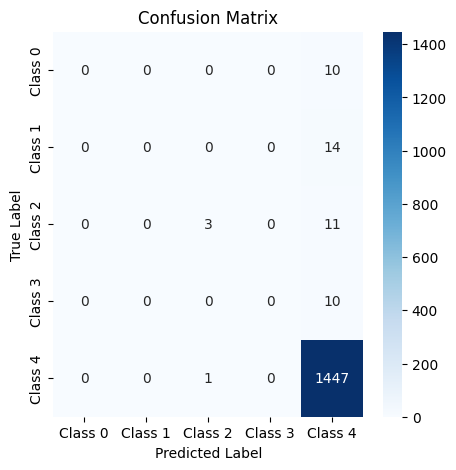

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        10
     Class 1       0.00      0.00      0.00        14
     Class 2       0.75      0.21      0.33        14
     Class 3       0.00      0.00      0.00        10
     Class 4       0.97      1.00      0.98      1448

    accuracy                           0.97      1496
   macro avg       0.34      0.24      0.26      1496
weighted avg       0.95      0.97      0.96      1496



c:\Users\Alexandra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alexandra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alexandra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [32]:
# 1. Faire des prédictions sur l'ensemble de test
y_pred_prob = my_mlp_model.predict(X_test)  # Prédictions sous forme de probabilités
y_pred = np.argmax(y_pred_prob, axis=1)    # Convertir les probabilités en classes

# 2. Convertir Y_test en classes (si Y_test est en one-hot encoding)
y_true = np.argmax(Y_test, axis=1)

# 3. Générer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(5)], 
            yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Générer et afficher le rapport de classification
class_report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)])
print("Classification Report:")
print(class_report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Comme prévu, on remarque que le modèle prédit uniquement la classe 4 cad Pas de Panne. Le modèle n'a pas la capacité à détecter les pannes. 

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [33]:
df = df[df[failure_types_ok].sum(axis=1) < 2]

conditions = [
    Y['TWF'] == 1,
    Y['HDF'] == 1,
    Y['PWF'] == 1,
    Y['OSF'] == 1,
    Y['NF'] == 1
]

choices = [0, 1, 2, 3, 4]

Y_single = np.select(conditions, choices, default=0)

# Convertir les étiquettes rééchantillonnées en format multilabel (one-hot encoding)
#Y_res_multilabel = np.zeros((Y_single.size, Y.shape[1]))
#Y_res_multilabel[np.arange(Y_single.size), Y_single] = 1

#Attention, avec cette version si une sample est 0 1 1 0 0 elle sera mise dans la classe 1 et la classe 2

# Appliquer le sur-échantillonnage avec SMOTE
smote = SMOTE(random_state=42)
X_res, Y_res = smote.fit_resample(X, Y_single)

#NORMALISATION DES DONNEES !!!!!!!!
#scaler = StandardScaler()
#X_res_normalized = scaler.fit_transform(X_res)


# Convertir les étiquettes rééchantillonnées en format multilabel (one-hot encoding)
Y_res_multilabel = np.zeros((Y_res.size, Y.shape[1]))
Y_res_multilabel[np.arange(Y_res.size), Y_res] = 1

# Vérifiez les nouvelles distributions de classes
print("Distribution originale des classes:", Counter(Y_single))
print("Nouvelle distribution des classes:", Counter(Y_res))

# Diviser les données
X_train, X_val, Y_train, Y_val = train_test_split(X_res, Y_res_multilabel, test_size=0.30, random_state=42) #modifier ici x_res a x_res_normalized
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

np.save('Xtest.npy', X_test)
np.save('Ytest.npy', Y_test)

Distribution originale des classes: Counter({np.int64(4): 9643, np.int64(1): 115, np.int64(2): 91, np.int64(3): 78, np.int64(0): 45})
Nouvelle distribution des classes: Counter({np.int64(4): 9643, np.int64(2): 9643, np.int64(0): 9643, np.int64(3): 9643, np.int64(1): 9643})


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Pour équilibrer le dataset, on utilise la technique SMOTE (Synthetic Minority Over-sampling Technique) pour générer des échantillons synthétiques des classes minoritaires. Cela permet de réduire le déséquilibre de classe et d'améliorer la capacité du modèle à apprendre à identifier les pannes.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [34]:
inputs = tf.keras.Input(shape=(5,)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


print(X_train.shape)
print(X_test.shape)

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

Shape of X: (9972, 5)
Shape of Y: (9972, 5)
(33750, 5)
(7233, 5)


**QUESTION** Code below the algorithms allowing to train model


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,869 (19.02 KB)

 Trainable params: 4,869 (19.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4196 - loss: 29.4335 - val_accuracy: 0.7016 - val_loss: 0.7858
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6411 - loss: 0.9240 - val_accuracy: 0.7518 - val_loss: 0.7109
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7246 - loss: 0.7475 - val_accuracy: 0.7526 - val_loss: 0.6584
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7340 - loss: 0.7080 - val_accuracy: 0.8237 - val_loss: 0.5203
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7560 - loss: 0.6929 - val_accuracy: 0.7651 - val_loss: 0.6322
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7926 - loss: 0.5945 - val_accuracy: 0.8410 - val_loss: 0.4760
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8192 - loss: 0.5309 - val_accuracy: 0.8541 - val_loss: 0.4623
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8048 - loss: 0.5510 - val_accuracy: 0

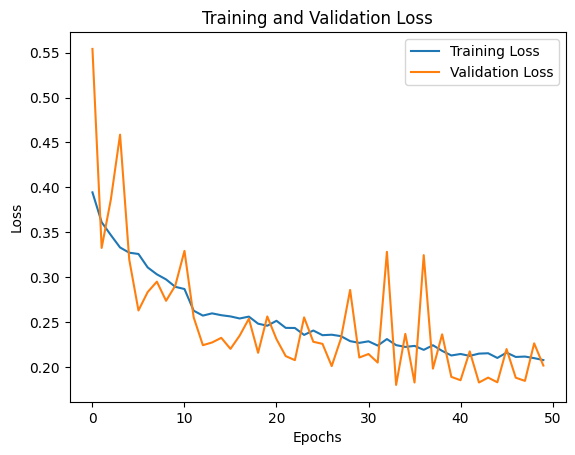

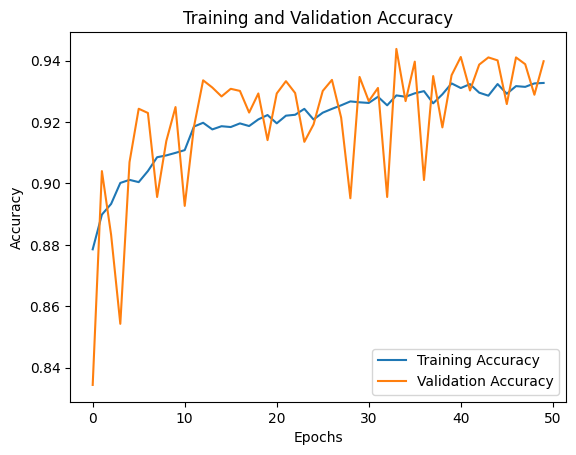

In [35]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(5,)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(64, activation='relu')(x) #a first hidden layer with 64 neurons
x = tf.keras.layers.Dense(64, activation='relu')(x) #a second hidden layer with 64 neurons
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD: 
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''

nb_epochs=50
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)


#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

#my_mlp_model.save('notre_model_aj.tflite')

history = my_mlp_model.fit(
    X_train, Y_train,                # Données d'entraînement
    epochs=50,                        # Nombre d'époques
    batch_size=32,                    # Taille du lot
    validation_data=(X_val, Y_val)  # Données de validation
)

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer la précision (accuracy)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
my_mlp_model.save('my_mlp_model.h5')

In [38]:
model = tf.keras.models.load_model('my_mlp_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(my_mlp_model)
tflite_model = converter.convert()
with open('my_mlp_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\ALEXAN~1\AppData\Local\Temp\tmpf73pi336\assets


INFO:tensorflow:Assets written to: C:\Users\ALEXAN~1\AppData\Local\Temp\tmpf73pi336\assets


Saved artifact at 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpf73pi336'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor_23')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2976563635664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976462514384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976563640080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976563639504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976563640272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976563638544: TensorSpec(shape=(), dtype=tf.resource, name=None)


**QUESTION** Plot the confusion matrix and the classification report

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


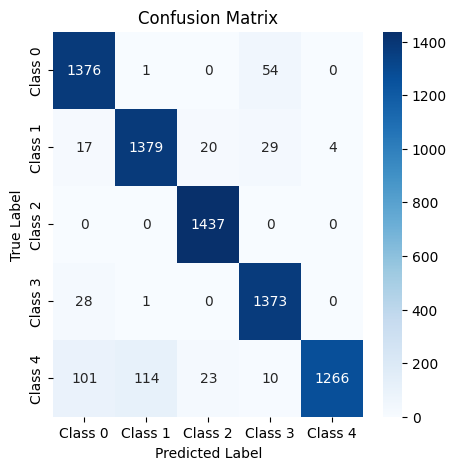

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93      1431
     Class 1       0.92      0.95      0.94      1449
     Class 2       0.97      1.00      0.99      1437
     Class 3       0.94      0.98      0.96      1402
     Class 4       1.00      0.84      0.91      1514

    accuracy                           0.94      7233
   macro avg       0.95      0.95      0.94      7233
weighted avg       0.95      0.94      0.94      7233



In [39]:
# 1. Faire des prédictions sur l'ensemble de test
y_pred_prob = my_mlp_model.predict(X_test)  # Prédictions sous forme de probabilités
y_pred = np.argmax(y_pred_prob, axis=1)    # Convertir les probabilités en classes

# 2. Convertir Y_test en classes (si Y_test est en one-hot encoding)
y_true = np.argmax(Y_test, axis=1)

# 3. Générer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(5)], 
            yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Générer et afficher le rapport de classification
class_report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)])
print("Classification Report:")
print(class_report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Après avoir équilibré le dataset, on observe une amélioration de la précision sur l'ensemble de validation. 

En utilisant SMOTE, nous remarquons, grâce à la matrice de confusion, que le modèle est bien plus performant. En effet, nous avons des valeurs très élevées sur la diagonale, ce qui nous montre que le label prédit correspond bien au label réel. La matrice de confusion indique également une meilleure capacité à prédire les classes minoritaires, ce qui est crucial pour la maintenance prédictive.

Nous avons donc réussi à faire un modèle efficace pour notre problème posé. 